## Introduction

With the advent of cryptocurrencies the world of economics will not be the same anylonger. To quote Napoleon: _"A revolution can neither be created nor stoped"_. Cryptos are becoming an intergral part of the industry, and along with Blockchain technology, they provide great topics for research, both in academia and outside of it. 

On the other end of the spectrum, the tremendous increase in computational power, especially over the last decade, combined with an abundance of collected data, has enabled AI researchers to test their early and ongoing theories about various neural network architectures. This in turn has created the so called Deep Learning field in AI. 

For newbies, I definetly recommend [this](http://index-of.es/Varios-2/Hands%20on%20Machine%20Learning%20with%20Scikit%20Learn%20and%20Tensorflow.pdf) book, which gives you exactly what you need for getting into DL even without extensive knowledge of math (although I admitt, prior knowledge on stats makes the learning process smoother).

Going further, I was really interested in both of them. I had some prior knowledge on neural networks (specifically MLP), but not at all on Bitcoin. However, I would listen to news about cryptocurrencies and bitcoin nonstop on BBC worldwide, youtube, twitter, and was really frustrated with my small understanding of it. Therefore I decided to merge Bitcoin with AI, by predicting the price of Ethereum and Bitcoin, so as to get the best of both worlds. 

Just to keep in mind: there are a lot more interesting stuff about bitcoin than the price! I will provide a list with some references about the Bitcoin invention. 


For this work, I have utilized the LSTM neural network, since it is created exactly for time-series problems, unlike MLP. I will predict bitcoin and ethereum. The reason being that, there is more data for bitcoin than there is for other cryptos, bitcoin was the first  crypto introducing us the blockchain, decentralized digital cash etc. On the other hand, I was interested in getting to know Smart Contracts, and how ethereum used bitcoin to create a complete other novel invention. 

### Data

I have used daily prices of Bitcoin, although some use minute-by-minute data, I believe there would be much overfitting that way. I use [coinmarketcap.com](https://coinmarketcap.com) to fetch the data on both ether and bitcoin. 

In [104]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Bitocin market data since 2013
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# Convert Date from string to Datetime type
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# Convert Volume to 0 when its '-'
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# Convert Volume to int type
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# Remove asterisks from Name column
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# Get a feel of it:

bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-09-10,6301.57,6374.98,6292.76,6329.70,3714100000,108759350260
1,2018-09-09,6223.38,6446.26,6201.22,6300.86,3671890000,107397286192
2,2018-09-08,6460.17,6534.25,6197.52,6225.98,3835060000,111471362532
3,2018-09-07,6528.92,6555.29,6396.87,6467.07,4264680000,112645200318
4,2018-09-06,6755.14,6755.14,6404.72,6529.17,5523470000,116535447253


In [105]:
# Same for ether
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-09-10,197.85,201.88,189.58,197.08,1502960000,20153125179
1,2018-09-09,198.38,207.67,188.31,196.92,1585980000,20203492382
2,2018-09-08,217.91,220.37,193.26,197.95,1517200000,22187693065
3,2018-09-07,229.53,233.90,217.07,217.20,1678260000,23366572107
4,2018-09-06,231.65,231.75,218.12,230.22,2097310000,23576873426


The data is fetched from [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/). As usual we have to do a bit of data cleaning. 
Just to prove that the data is accurate, we can plot the price and volume of both cryptocurrencies over time.

In [106]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [107]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

print(bitcoin_market_info)

           Date  bt_Open  bt_High   bt_Low  bt_Close   bt_Volume  \
0    2018-09-10  6301.57  6374.98  6292.76   6329.70  3714100000   
1    2018-09-09  6223.38  6446.26  6201.22   6300.86  3671890000   
2    2018-09-08  6460.17  6534.25  6197.52   6225.98  3835060000   
3    2018-09-07  6528.92  6555.29  6396.87   6467.07  4264680000   
4    2018-09-06  6755.14  6755.14  6404.72   6529.17  5523470000   
5    2018-09-05  7361.46  7388.43  6792.83   6792.83  5800460000   
6    2018-09-04  7263.00  7388.26  7255.44   7361.66  4273640000   
7    2018-09-03  7279.03  7317.94  7208.15   7260.06  4087760000   
8    2018-09-02  7189.58  7306.31  7132.16   7272.72  4329540000   
9    2018-09-01  7044.81  7242.29  7038.05   7193.25  4116050000   
10   2018-08-31  6973.97  7057.17  6920.16   7037.58  4495650000   
11   2018-08-30  7043.76  7072.69  6834.69   6978.23  4463250000   
12   2018-08-29  7091.71  7113.30  6970.82   7047.16  4145880000   
13   2018-08-28  6891.08  7109.56  6882.34   709

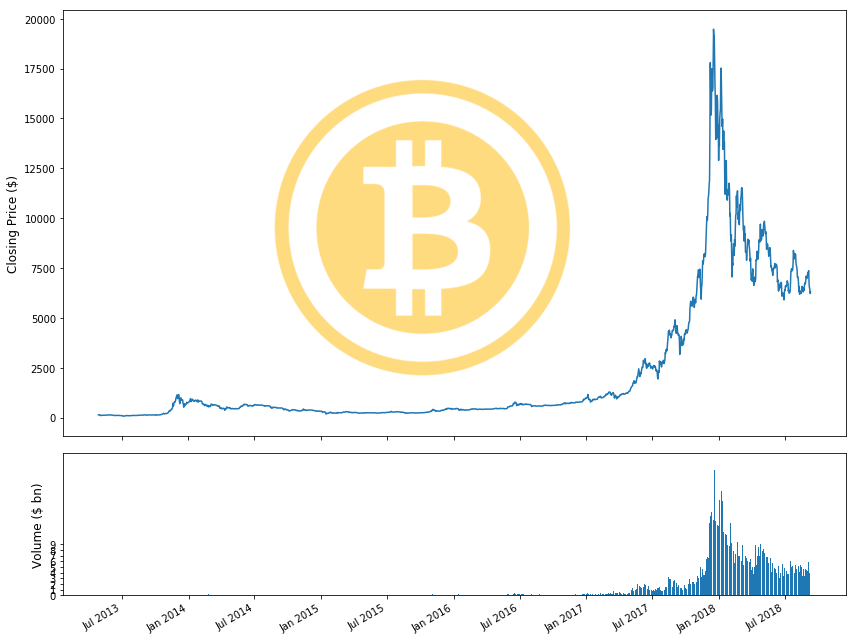

In [53]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
fig.autofmt_xdate()
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 170, zorder=3,alpha=.5)
plt.show()

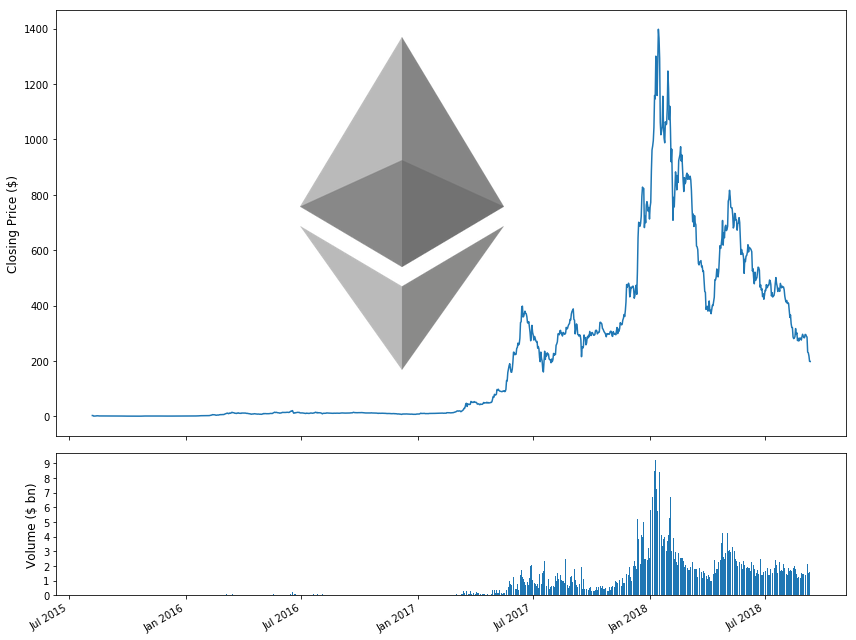

In [50]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
fig.autofmt_xdate()
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 270, zorder=3, alpha=.6)
plt.show()

In [54]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-09-10,6301.57,6374.98,6292.76,6329.70,3714100000,108759350260,197.85,201.88,189.58,197.08,1502960000,20153125179,0.004464,-0.003892
1,2018-09-09,6223.38,6446.26,6201.22,6300.86,3671890000,107397286192,198.38,207.67,188.31,196.92,1585980000,20203492382,0.012450,-0.007360
2,2018-09-08,6460.17,6534.25,6197.52,6225.98,3835060000,111471362532,217.91,220.37,193.26,197.95,1517200000,22187693065,-0.036251,-0.091597
3,2018-09-07,6528.92,6555.29,6396.87,6467.07,4264680000,112645200318,229.53,233.90,217.07,217.20,1678260000,23366572107,-0.009473,-0.053718
4,2018-09-06,6755.14,6755.14,6404.72,6529.17,5523470000,116535447253,231.65,231.75,218.12,230.22,2097310000,23576873426,-0.033452,-0.006173


### Training, Test

Typically the test data gets split into training, test, and validation data sets. The model is built using the training set, afterwards, the test set is used to evaluate the model. 
We generally train on one period of time and then test on another separate period. Rather arbitrary, I'll set the cut-off date to February 1st 2018. The model will be trained on data before that date (unfortunately we'll have to make use even of data on 2013-2015 when Bitcoin wasn't that popular), and after this the remaining is left for testing :)

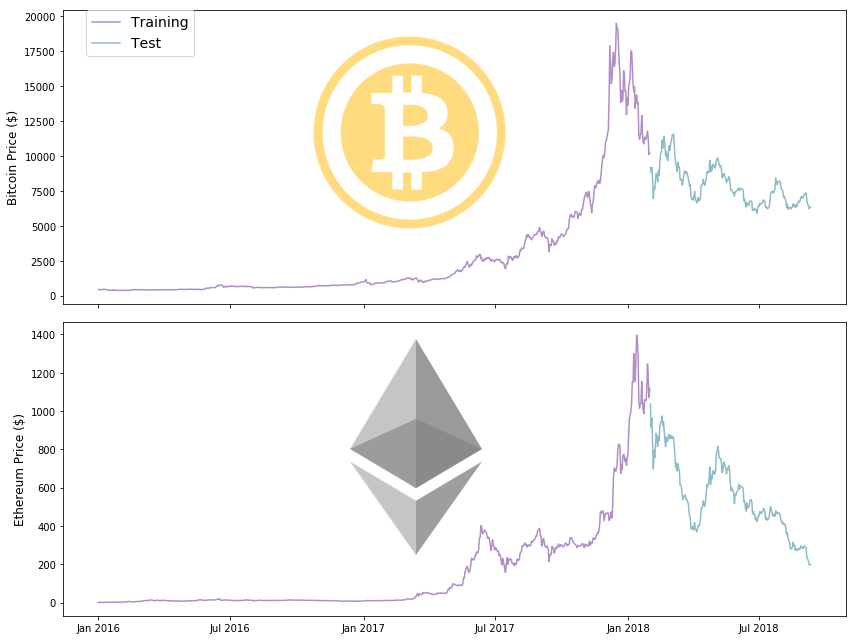

In [63]:
split_date = '2018-02-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 350, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 85, zorder=3,alpha=.5)
plt.show()

Firstly, let's check whether the daily change in price follow a normal distribution.One way to see this is by ploting the histograms

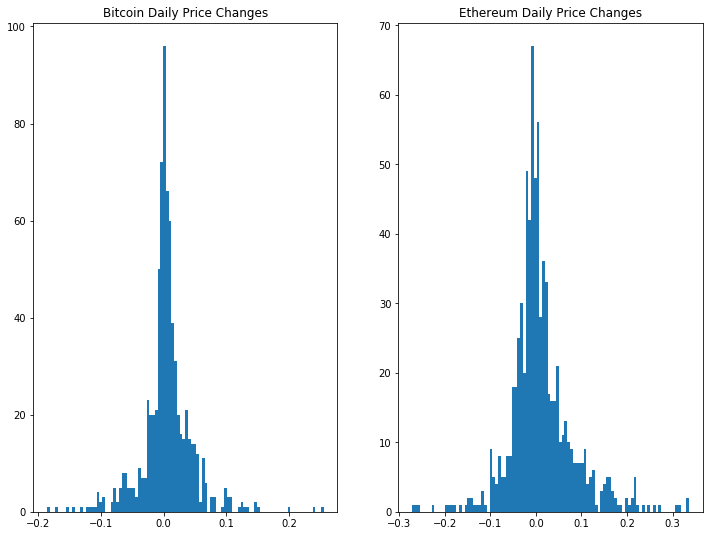

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

## Long Short Term Memory (LSTM)

For LSTM Theory read: [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [this](http://blog.echen.me/2017/05/30/exploring-lstms/) and [this](http://www.bioinf.jku.at/publications/older/2604.pdf). Nevertheless, various implementations of deep learning algorithms are provided out of the box by different packages (e.g. [TensorFlow](https://www.tensorflow.org/get_started/get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). Here I use Keras, since it's really really convinient and was build with tensorflow in mind ;)

In [70]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [72]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.tail()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-09-06,6529.17,5523470000,0.289709,0.051875,230.22,2097310000,-0.775495,0.058839
3,2018-09-07,6467.07,4264680000,0.113748,0.024264,217.20,1678260000,0.984551,0.073324
2,2018-09-08,6225.98,3835060000,0.830962,0.052124,197.95,1517200000,0.654002,0.124409
1,2018-09-09,6300.86,3671890000,0.186745,0.039374,196.92,1585980000,0.110537,0.097590
0,2018-09-10,6329.70,3714100000,0.101435,0.013048,197.08,1502960000,-0.219512,0.062168


In [73]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [74]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [75]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [76]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [77]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
983,0.000000,0.000000,-0.560137,0.020268,0.000000,0.000000,-0.418477,0.025040
982,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
981,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
980,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
979,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
978,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
977,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
976,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
975,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
974,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


In [78]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [80]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [81]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 8s - loss: 0.1455
Epoch 2/50
 - 9s - loss: 0.0963
Epoch 3/50
 - 11s - loss: 0.0877
Epoch 4/50
 - 9s - loss: 0.0797
Epoch 5/50
 - 10s - loss: 0.0776
Epoch 6/50
 - 11s - loss: 0.0774
Epoch 7/50
 - 8s - loss: 0.0704
Epoch 8/50
 - 11s - loss: 0.0686
Epoch 9/50
 - 8s - loss: 0.0704
Epoch 10/50
 - 4s - loss: 0.0676
Epoch 11/50
 - 11s - loss: 0.0681
Epoch 12/50
 - 10s - loss: 0.0678
Epoch 13/50
 - 6s - loss: 0.0669
Epoch 14/50
 - 7s - loss: 0.0663
Epoch 15/50
 - 6s - loss: 0.0671
Epoch 16/50
 - 7s - loss: 0.0649
Epoch 17/50
 - 5s - loss: 0.0667
Epoch 18/50
 - 10s - loss: 0.0677
Epoch 19/50
 - 5s - loss: 0.0649
Epoch 20/50
 - 4s - loss: 0.0672
Epoch 21/50
 - 4s - loss: 0.0633
Epoch 22/50
 - 9s - loss: 0.0628
Epoch 23/50
 - 7s - loss: 0.0637
Epoch 24/50
 - 7s - loss: 0.0638
Epoch 25/50
 - 7s - loss: 0.0623
Epoch 26/50
 - 4s - loss: 0.0617
Epoch 27/50
 - 4s - loss: 0.0652
Epoch 28/50
 - 4s - loss: 0.0638
Epoch 29/50
 - 4s - loss: 0.0636
Epoch 30/50
 - 7s - loss: 0.0650
Epoch 31/50


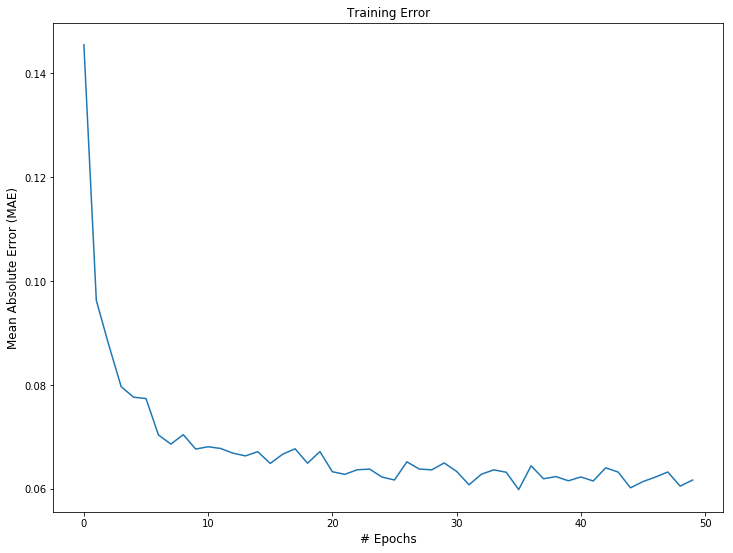

In [83]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

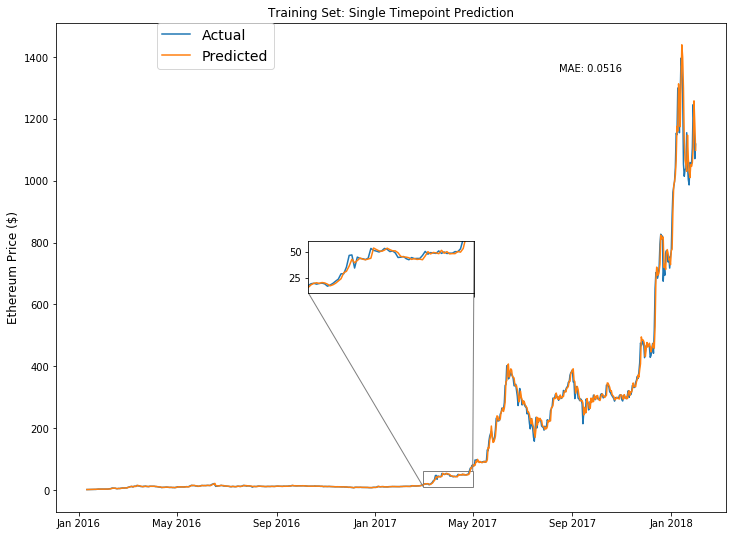

In [84]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

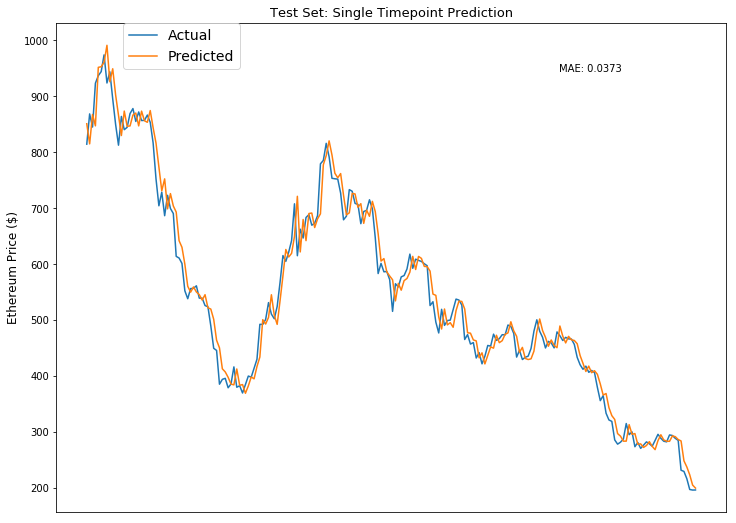

In [85]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [86]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 4s - loss: 0.1002
Epoch 2/50
 - 4s - loss: 0.0597
Epoch 3/50
 - 4s - loss: 0.0494
Epoch 4/50
 - 5s - loss: 0.0456
Epoch 5/50
 - 5s - loss: 0.0416
Epoch 6/50
 - 4s - loss: 0.0423
Epoch 7/50
 - 4s - loss: 0.0385
Epoch 8/50
 - 5s - loss: 0.0369
Epoch 9/50
 - 4s - loss: 0.0367
Epoch 10/50
 - 4s - loss: 0.0354
Epoch 11/50
 - 4s - loss: 0.0354
Epoch 12/50
 - 7s - loss: 0.0357
Epoch 13/50
 - 5s - loss: 0.0336
Epoch 14/50
 - 4s - loss: 0.0336
Epoch 15/50
 - 4s - loss: 0.0345
Epoch 16/50
 - 4s - loss: 0.0338
Epoch 17/50
 - 5s - loss: 0.0343
Epoch 18/50
 - 5s - loss: 0.0341
Epoch 19/50
 - 5s - loss: 0.0337
Epoch 20/50
 - 5s - loss: 0.0326
Epoch 21/50
 - 4s - loss: 0.0335
Epoch 22/50
 - 5s - loss: 0.0336
Epoch 23/50
 - 5s - loss: 0.0324
Epoch 24/50
 - 5s - loss: 0.0339
Epoch 25/50
 - 6s - loss: 0.0328
Epoch 26/50
 - 5s - loss: 0.0316
Epoch 27/50
 - 5s - loss: 0.0325
Epoch 28/50
 - 5s - loss: 0.0322
Epoch 29/50
 - 5s - loss: 0.0331
Epoch 30/50
 - 5s - loss: 0.0326
Epoch 31/50
 - 5s -

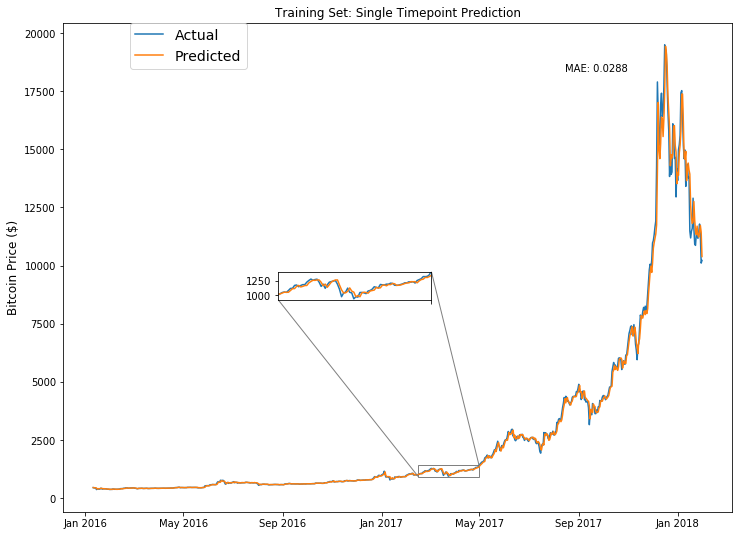

In [87]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

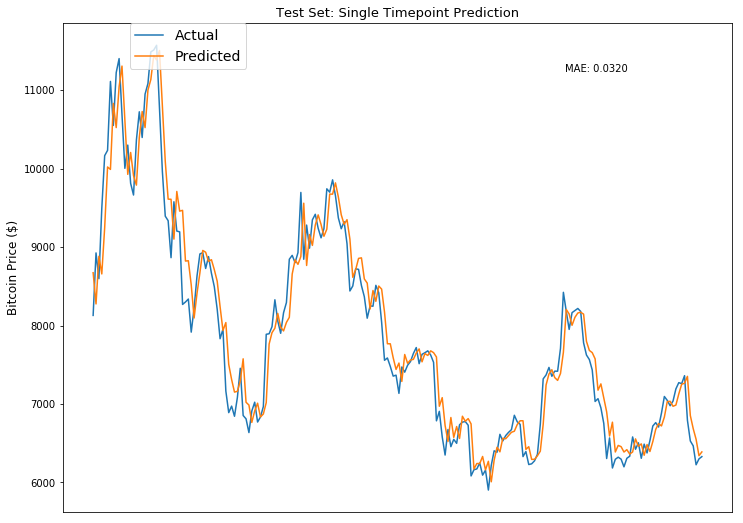

In [88]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [89]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.1934
Epoch 2/50
 - 4s - loss: 0.1364
Epoch 3/50
 - 4s - loss: 0.1308
Epoch 4/50
 - 4s - loss: 0.1210
Epoch 5/50
 - 4s - loss: 0.1199
Epoch 6/50
 - 4s - loss: 0.1162
Epoch 7/50
 - 4s - loss: 0.1160
Epoch 8/50
 - 5s - loss: 0.1130
Epoch 9/50
 - 5s - loss: 0.1148
Epoch 10/50
 - 5s - loss: 0.1135
Epoch 11/50
 - 5s - loss: 0.1132
Epoch 12/50
 - 5s - loss: 0.1119
Epoch 13/50
 - 5s - loss: 0.1089
Epoch 14/50
 - 4s - loss: 0.1103
Epoch 15/50
 - 5s - loss: 0.1116
Epoch 16/50
 - 5s - loss: 0.1094
Epoch 17/50
 - 5s - loss: 0.1078
Epoch 18/50
 - 5s - loss: 0.1096
Epoch 19/50
 - 5s - loss: 0.1074
Epoch 20/50
 - 5s - loss: 0.1093
Epoch 21/50
 - 5s - loss: 0.1091
Epoch 22/50
 - 5s - loss: 0.1073
Epoch 23/50
 - 5s - loss: 0.1111
Epoch 24/50
 - 5s - loss: 0.1087
Epoch 25/50
 - 5s - loss: 0.1070
Epoch 26/50
 - 5s - loss: 0.1076
Epoch 27/50
 - 5s - loss: 0.1072
Epoch 28/50
 - 5s - loss: 0.1068
Epoch 29/50
 - 5s - loss: 0.1051
Epoch 30/50
 - 4s - loss: 0.1063
Epoch 31/50
 - 5s -

In [93]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 5s - loss: 0.1089
Epoch 2/50
 - 5s - loss: 0.0725
Epoch 3/50
 - 4s - loss: 0.0649
Epoch 4/50
 - 5s - loss: 0.0609
Epoch 5/50
 - 5s - loss: 0.0603
Epoch 6/50
 - 5s - loss: 0.0584
Epoch 7/50
 - 4s - loss: 0.0568
Epoch 8/50
 - 5s - loss: 0.0553
Epoch 9/50
 - 5s - loss: 0.0552
Epoch 10/50
 - 4s - loss: 0.0558
Epoch 11/50
 - 4s - loss: 0.0548
Epoch 12/50
 - 4s - loss: 0.0550
Epoch 13/50
 - 4s - loss: 0.0553
Epoch 14/50
 - 4s - loss: 0.0547
Epoch 15/50
 - 4s - loss: 0.0535
Epoch 16/50
 - 4s - loss: 0.0537
Epoch 17/50
 - 4s - loss: 0.0527
Epoch 18/50
 - 4s - loss: 0.0548
Epoch 19/50
 - 4s - loss: 0.0535
Epoch 20/50
 - 4s - loss: 0.0535
Epoch 21/50
 - 4s - loss: 0.0538
Epoch 22/50
 - 4s - loss: 0.0534
Epoch 23/50
 - 4s - loss: 0.0526
Epoch 24/50
 - 4s - loss: 0.0543
Epoch 25/50
 - 4s - loss: 0.0526
Epoch 26/50
 - 4s - loss: 0.0526
Epoch 27/50
 - 4s - loss: 0.0534
Epoch 28/50
 - 4s - loss: 0.0517
Epoch 29/50
 - 4s - loss: 0.0524
Epoch 30/50
 - 4s - loss: 0.0520
Epoch 31/50
 - 4s -

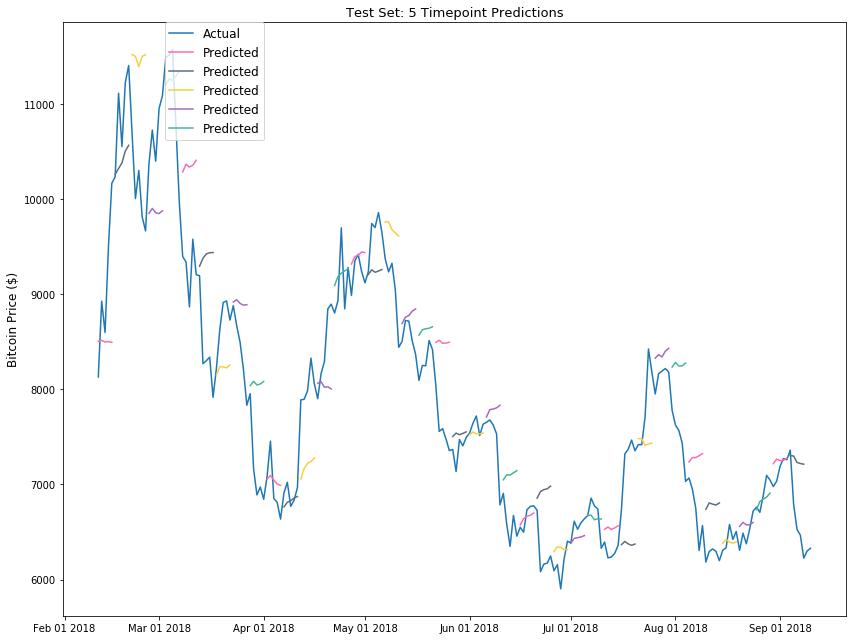

In [102]:
# little bit of reformatting the predictions to closing prices
# eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
#                    test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1) = plt.subplots(1,1)

fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
# ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
# ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
#          test_set['eth_Close'][window_len:], label='Actual')
for i, (bt_pred) in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
#     ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
#              eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
# ax1.set_xticklabels('')
# ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [96]:
# warning: this cell may take some time to execute
# this code builds 25 LSTM models for eth and bitcoin each (with 25 different initialisations)
# the models are then saved so you hopefully only need to run this cell once

# random seed for reproducibility
# for rand_seed in range(775,800):
#     print(rand_seed)
#     np.random.seed(rand_seed)
#     temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
#     temp_model.fit(LSTM_training_inputs,
#                  (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1,
#                  epochs=50, batch_size=1, verbose=0, shuffle=True)
#     temp_model.save('eth_model_randseed_%d.h5'%rand_seed)
#     temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
#     temp_model.fit(LSTM_training_inputs,
#                  (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1,
#                  epochs=50, batch_size=1, verbose=0, shuffle=True)
#     temp_model.save('bt_model_randseed_%d.h5'%rand_seed)

In [ ]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

from keras.models import load_model

eth_preds = []
bt_preds = []
for rand_seed in range(775,800):
    temp_model = load_model('eth_model_randseed_%d.h5'%rand_seed)
    eth_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['eth_Close'].values[window_len:]/test_set['eth_Close'].values[:-window_len]-1))))
    temp_model = load_model('bt_model_randseed_%d.h5'%rand_seed)
    bt_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['bt_Close'].values[window_len:]/test_set['bt_Close'].values[:-window_len]-1))))

In [ ]:
eth_random_walk_preds = []
bt_random_walk_preds = []
for rand_seed in range(775,800):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close'][window_len:])/np.array(test_set['eth_Close'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close'][window_len:])/np.array(test_set['bt_Close'][:-window_len]))))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0, 0.2])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (25 runs)')
ax2.set_title('Ethereum Test Set (25 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.show()

## Summary

All in all, we collected some crypto data and fed it into LSTM deep layered network, you definitely don't have to be an expert to make use of keras, although I am suspicious whether you'd feel good without understanding any bit of it.
I do feel sceptic on LSTM though, and will try GRU and min GRU, also I will have to make a yearly prediction, which in my opinion is scary considering the volatility of the market.
I will always tweak the model by:

* **Changing Loss Functions**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

I will also try to use [Facebook Prophet Algorithm](https://github.com/facebook/prophet), I feel really intrigued by it since it targets time-series only!